In [1]:
import math
import os
import re
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, log_loss)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tqdm import tqdm

In [16]:
pokemon_type_train: str = "Water"

train_data_images: str = "images-gen-1-8"
train_data_labels: str = "pokemon-gen-1-8.csv"

model_test_size: float = 0.2
model_learning_rate: float = 0.001
model_epochs: int = 10
model_batch_size: int = 120

In [3]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

In [5]:
# Process Pokémon and one-hot encode the types

pokemon = pd.read_csv(PROJECT_ROOT / 'data/external/stats' / train_data_labels)
pokemon = pokemon[["pokedex_number", "name", "type1", "type2"]]

# Create one-hot columns for each type
types = set(pokemon["type1"])
for t in types:
    pokemon["is" + str(t).capitalize()] = 0

# Iterate over Pokémon
for i, p in pokemon.iterrows():
    
    #  Set one-hot columns to 1 for relevant types
    pokemon.loc[i, "is" + p["type1"].capitalize()] = 1

    if not pd.isna(p["type2"]):
        pokemon.loc[i, "is" + p["type2"].capitalize()] = 1

# Save output
pokemon.to_csv(PROJECT_ROOT / 'data/processed/pokemon.csv', index=False)

pokemon.head()

,pokedex_number,name,type1,type2,isNormal,isIce,isSteel,isWater,isGhost,isFlying,...,isGround,isFairy,isElectric,isDragon,isDark,isGrass,isBug,isPsychic,isFire,isFighting
0,1,Bulbasaur,grass,poison,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,Ivysaur,grass,poison,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,Venusaur,grass,poison,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# Process image data

data_directory_images = PROJECT_ROOT / "data/external" / train_data_images
output_directory = PROJECT_ROOT / "data/processed/pokemon"

pokemon = pd.read_csv(PROJECT_ROOT / 'data/processed/pokemon.csv')
pokemon["imagePath"] = np.nan

# Remove processed folder and create empty new one
try:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
except:
    os.mkdir(output_directory)

# Copy images to processed folder
for image in os.listdir(data_directory_images):
    pokemon_id = image.split('.')[0]
    
    # Add leading zeroes to ID
    while len(pokemon_id) < 3:
        pokemon_id = "0" + pokemon_id

    # Images with no variety (e.g. "211.png")
    if pokemon_id.isnumeric():
        
        # Copy to processed folder
        src = data_directory_images / image
        dst = os.path.join(output_directory, pokemon_id + ".png")
        shutil.copyfile(src, dst)

        # Set image path in data frame
        pokemon.loc[pokemon["pokedex_number"] == int(pokemon_id), 'imagePath'] = dst
        

# Drop Pokemon without image path
pokemon = pokemon.dropna(subset=["imagePath"])

# Save pokemon.csv with image paths
pokemon.to_csv(PROJECT_ROOT / 'data/processed/pokemon-with-image-paths.csv', index=False)

pokemon.head()

,pokedex_number,name,type1,type2,isNormal,isIce,isSteel,isWater,isGhost,isFlying,...,isFairy,isElectric,isDragon,isDark,isGrass,isBug,isPsychic,isFire,isFighting,imagePath
0,1,Bulbasaur,grass,poison,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
1,2,Ivysaur,grass,poison,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
2,3,Venusaur,grass,poison,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/Users/robdewit/Documents/example-pokemon-clas...
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/Users/robdewit/Documents/example-pokemon-clas...


In [7]:
# Load images as training data
train_image = []

for i in tqdm(range(pokemon.shape[0])):
    
    img = tf.keras.utils.load_img(pokemon.iloc[i]["imagePath"], color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

# Set dimensions for input sizes later on
model_image_size_x = len(X[1])
model_image_size_y = len(X[2])

X.shape

100%|████████████████████████████████████████████████████████████████████████████████| 801/801 [00:04<00:00, 181.63it/s]


(801, 475, 475, 4)

In [8]:
# Create labels
y = pokemon[["is" + pokemon_type_train]]
y.shape

(801, 1)

In [9]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=model_test_size, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 475, 475, 4) (640, 1)
(161, 475, 475, 4) (161, 1)


In [10]:
img_input = layers.Input(shape=(model_image_size_x, model_image_size_y, 4))

model = Sequential()

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(model_image_size_x, model_image_size_y, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))

model.add(Dense(8, activation="relu"))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate) #Adam, RMSprop or SGD

model.compile(
    loss='binary_crossentropy'
    , optimizer=optimizer
    , metrics=[keras.metrics.AUC()]
#     , metrics=[keras.metrics.Recall()]
)

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 471, 471, 4)       404       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 235, 235, 4)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 235, 235, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 231, 231, 4)       404       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 115, 115, 4)      0         
 2D)                                                             
                                                                 
 dense (Dense)        

2022-08-29 16:13:47.620057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-29 16:13:47.620223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2022-08-29 16:13:50.959813: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-29 16:13:51.376963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.6890 - auc: 0.4828

2022-08-29 16:13:54.730102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 4s 566ms/step - loss: 0.6890 - auc: 0.4828 - val_loss: 1.4250 - val_auc: 0.5452
Epoch 2/10
6/6 [==============================] - 3s 489ms/step - loss: 0.3377 - auc: 0.5460 - val_loss: 0.5472 - val_auc: 0.6125
Epoch 3/10
6/6 [==============================] - 3s 445ms/step - loss: 0.3036 - auc: 0.5930 - val_loss: 0.7173 - val_auc: 0.5615
Epoch 4/10
6/6 [==============================] - 2s 401ms/step - loss: 0.2534 - auc: 0.6145 - val_loss: 0.7715 - val_auc: 0.5484
Epoch 5/10
6/6 [==============================] - 2s 391ms/step - loss: 0.2520 - auc: 0.6666 - val_loss: 0.7783 - val_auc: 0.5486
Epoch 6/10
6/6 [==============================] - 2s 388ms/step - loss: 0.2495 - auc: 0.7177 - val_loss: 0.7713 - val_auc: 0.5368
Epoch 7/10
6/6 [==============================] - 2s 394ms/step - loss: 0.2440 - auc: 0.7852 - val_loss: 0.7008 - val_auc: 0.5296
Epoch 8/10
6/6 [==============================] - 2s 391ms/step - loss: 0.2339 - auc: 0.8207 - val_lo

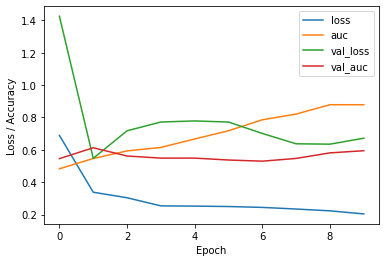

In [11]:
# Now train the model

def calculate_class_weights(y_train):
    ratio_true = sum(y_train["isWater"] == 1) / len(y_train["isWater"])
    ratio_false = sum(y_train["isWater"] != 1) / len(y_train["isWater"])

    return {0: ratio_true, 1: ratio_false}


estimator = model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test),
                      class_weight= calculate_class_weights(y_train),
                      epochs=model_epochs, 
                      batch_size=model_batch_size,
                      verbose=1)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')

for k in estimator.history.keys():
    plt.plot(estimator.history[k], label = k) 
plt.legend(loc='best')
plt.show()


0.60496354


2022-08-29 16:15:55.875897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


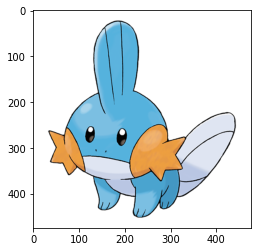

In [12]:
def predict_pokemon(id: str, verbose=0):
    
    while len(id) < 3:
        id = "0" + id
    
    img = tf.keras.utils.load_img(f'{PROJECT_ROOT}/data/processed/pokemon/{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,475,475,4), verbose=verbose)
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]

print(predict_pokemon("258"))

26/26 [==============================] - 1s 33ms/step


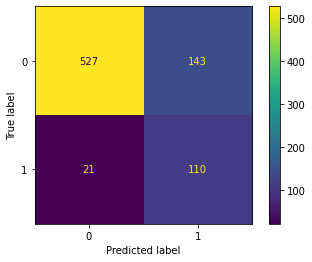

In [13]:
predictions = model.predict(X) > 0.5
cm = confusion_matrix(y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Attribution:

https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080
https://www.kaggle.com/datasets/rounakbanik/pokemon